In [40]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
caucus_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/ProcessedCaucus.csv')

In [43]:
caucus_df['docTokens'].isna().value_counts()

docTokens
False    193
True       4
Name: count, dtype: int64

In [44]:
import pandas as pd
caucus_df = caucus_df.dropna(subset=['docTokens'])

In [45]:
caucus_df

,Unnamed: 0,Date,Member,Party,State / District,Title,Press Release,Caucus,sentences,docTokens
0,0,May 12,Ayanna Pressley,D,Mass.-7,"WATCH: In Powerful Mothers Day Speech, Pressle...","May 12, 2024 “Mr. Speaker, mothers across Amer...",Congress Progressive,"['may mr', 'speaker mother across america want...",may mr speaker mother across america want hall...
1,1,May 10,Morgan Griffith,R,Va.-9,Congressman Griffiths Weekly E-Newsletter 5.10.24,It has been roughly four and a half years sinc...,Freedom Party,['roughly four half year since start pandemic ...,roughly four half year since start pandemic de...
2,2,May 10,Nanette Barragán,D,Calif.-44,Affordable housing crisis looms large in election,"The Hill | Taylor Giorno May 1, 2024 “Congre...",Congress Progressive,['hill taylor giorno may congress part create ...,hill taylor giorno may congress part create fl...
3,3,May 8,John Moolenaar,R,Mich.-2,Congressman Moolenaar Named Chairman of the Ho...,Subscribe to Congressman Moolenaar's Newslette...,Main Street,['subscribe congressman moolenaar newsletter w...,subscribe congressman moolenaar newsletter web...
4,4,May 9,Morgan Griffith,R,Va.-9,Griffith Celebrates Approximately $75 Million ...,The U.S. Department of the Interior’s National...,Freedom Party,['department interior national park service np...,department interior national park service np a...
...,...,...,...,...,...,...,...,...,...,...
192,195,April 11,Mike Levin,D,Calif.-49,SEEC Clean Energy Deployment Task Force Co-Cha...,"Washington, D.C. — Today, the Co-Chairs of the...",Congress Progressive,['washington today house sustainable energy en...,washington today house sustainable energy envi...
193,196,April 12,Mike Levin,D,Calif.-49,Rep. Levin and House Natural Resources Committ...,"Washington, D.C.- Rep. Mike Levin (D-Calif) jo...",Congress Progressive,['washington mike levin joined house natural r...,washington mike levin joined house natural res...
194,197,April 12,Mike Levin,D,Calif.-49,Rep. Mike Levin and San Diego Congressional De...,"Washington, D.C. – Today, Rep. Mike Levin (CA-...",Congress Progressive,['washington today mike levin announced fellow...,washington today mike levin announced fellow m...
195,198,April 11,Jared Huffman,D,Calif.-2,Rep. Huffman Statement on 2024 Salmon Season C...,"Washington, D.C. – Today, U.S. Representative ...",Congress Progressive,['washington today representative jared huffma...,washington today representative jared huffman ...


## TD-IDF based on Caucus full documents

In [46]:
from sklearn.model_selection import train_test_split

X_train, x_val, y_train, y_val = train_test_split(caucus_df['docTokens'], caucus_df['Caucus'], test_size=0.2, stratify=caucus_df['Caucus'])
print(f'Training samples: {len(X_train)}')
print(f'Validation samples: {len(x_val)}')

Training samples: 154
Validation samples: 39


In [47]:

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False)

y_train_ohe = ohe.fit_transform(y_train.values.reshape(-1, 1))
y_val_ohe = ohe.transform(y_val.values.reshape(-1, 1))

print(f'One hot encoded training labels shape: {y_train_ohe.shape}')
print(f'One hot encoded validation labels shape: {y_val_ohe.shape}')


One hot encoded training labels shape: (154, 4)
One hot encoded validation labels shape: (39, 4)


In [48]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_le = label_encoder.fit_transform(y_train)
y_val_le = label_encoder.transform(y_val)

print(f'Label encoded training labels shape: {y_train_le.shape}')
print(f'Label encoded validation labels shape: {y_val_le.shape}')

Label encoded training labels shape: (154,)
Label encoded validation labels shape: (39,)


In [49]:
for i in range(5):
    print(f'Original label: {y_train.iloc[i]} - Label encoded: {y_train_le[i]}')

Original label: Congress Progressive - Label encoded: 0
Original label: Freedom Party - Label encoded: 1
Original label: Congress Progressive - Label encoded: 0
Original label: New Democrat Coalition - Label encoded: 3
Original label: Congress Progressive - Label encoded: 0


Freedom = 1
Progressive = 0
New Dem = 3
Main Street = 2

In [50]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

In [51]:
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC(kernel='linear', C=1.0, random_state=42))
])

# fit the model
text_clf.fit(X_train, y_train_le)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', SVC(kernel='linear', random_state=42))])

In [52]:
text_clf.score(x_val, y_val_le)

0.8205128205128205

In [53]:
import pickle

model_path = "/content/drive/My Drive/Colab Notebooks/caucus_model_tfidf.pkl"
with open(model_path, 'wb') as f:
    pickle.dump(text_clf, f)

In [72]:
text_clf.predict(caucus_df['docTokens'])

array([0, 1, 0, 2, 1, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 3, 2, 0, 3, 3, 3, 3,
       0, 2, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 3, 2, 0, 1, 3,
       1, 1, 0, 0, 3, 1, 1, 3, 3, 2, 2, 2, 2, 0, 0, 1, 0, 3, 0, 3, 1, 1,
       1, 0, 0, 1, 3, 3, 0, 0, 3, 3, 3, 2, 0, 0, 0, 1, 3, 3, 2, 2, 2, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 0, 2,
       2, 2, 1, 3, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 2, 0, 0, 0, 1, 0, 0,
       0, 0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 1, 0, 1, 3, 0, 0, 0, 0, 0, 2, 3,
       3, 3, 0, 0, 2, 2, 0, 2, 2, 0, 0, 1, 3, 3, 3, 3, 3, 3, 0, 2, 0, 0,
       1, 3, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## RNN – Document Level

In [54]:
import random

# sample a random sentence from the training set
random_idx = random.randint(0, len(X_train))
print(f'Random Document: {X_train.iloc[random_idx]}')
print(f'Caucus: {y_train.iloc[random_idx]}')

Random Document: congresswoman chellie pingree ranking member house appropriation interior environment related agency subcommittee today emphasized importance bolstering climate change resilience supporting tribal acadia national park national park across county budget hearing morning department interior doi secretary deb haaland pingree highlighted new funding inflation reduction act acadia national park used implement seeing model meaningfully integrate indigenous knowledge western science project build year consultation acadia national park saint croix island international historic site roosevelt campobello international park wabanaki tribe pingree said hearing one example amazing work inflation reduction act funding support prepare park across country resilient climate february national park service announced million climate restoration resilience project next decade secretary haaland said national park service budget includes million additional climate vulnerability study million 

In [55]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False)

y_train_ohe = ohe.fit_transform(y_train.values.reshape(-1, 1))
y_val_ohe = ohe.transform(y_val.values.reshape(-1, 1))

print(f'One hot encoded training labels shape: {y_train_ohe.shape}')
print(f'One hot encoded validation labels shape: {y_val_ohe.shape}')

One hot encoded training labels shape: (154, 4)
One hot encoded validation labels shape: (39, 4)


In [56]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Create a TextVectorization layer
text_vectorizer = TextVectorization(
    max_tokens=10000,  # Maximum size of the vocabulary
    output_mode='int',          # Output the token indices as integers
    output_sequence_length=550,  # Length of output sequences
    pad_to_max_tokens=True      # Pad sequences to max_tokens
)

In [57]:
import random

text_vectorizer.adapt(X_train.values)

example_sent = random.choice(X_train.values)
print(f'Original text:\n{example_sent}')
print(f'\nVectorized text:\n{text_vectorizer([example_sent])}')
print('Length of vector:', len(text_vectorizer([example_sent]).numpy()[0]))

Original text:
may mr speaker mother across america want hallmark card want policy see center serve would prefer bouquet verbal video youtube boston congresswoman ayanna pressley marked mother day powerful speech house floor called meaningful policy change better support mother caregiver including maternal health justice affordable childcare universal paid leave reproductive freedom home service footage speech found transcript transcript powerful mother day speech ayanna pressley call policy change support mother caregiver march house representative time year speaker wax poetic contribution mother call work valued love endless role invaluable speaker mother across america want hallmark card want policy change grew small storefront church southside chicago grandfather pastor even pastor would often say would rather see sermon hear one speaker mother country deserving policy policy see center serve would prefer bouquet verbal otherwise tell mother caregiving greatest contribution undermi

In [58]:
vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in the vocabulary: {len(vocab)}')
print(f'Most common words in the vocabulary: {vocab[:5]}')
print(f'Least common words in the vocabulary: {vocab[-5:]}')

Number of words in the vocabulary: 7291
Most common words in the vocabulary: ['', '[UNK]', 'community', 'said', 'act']
Least common words in the vocabulary: ['abordará', 'abordar', 'abby', 'aanhpis', 'aamft']


In [59]:
text_vectorizer.get_config()

{'name': 'text_vectorization_1',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 10000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 550,
 'pad_to_max_tokens': True,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 7291}

In [60]:
token_embedding = tf.keras.layers.Embedding(input_dim=len(vocab),
                                            output_dim=128,
                                            mask_zero=True,
                                            name='token_embedding')

print(f'Sentence before vectorization: {example_sent}')
vectorized_sent = text_vectorizer(example_sent)
print(f'Sentence after vectorization: {vectorized_sent}')
embedded_sent = token_embedding(vectorized_sent)
print(f'Sentence after embedding: {embedded_sent}')

Sentence before vectorization: may mr speaker mother across america want hallmark card want policy see center serve would prefer bouquet verbal video youtube boston congresswoman ayanna pressley marked mother day powerful speech house floor called meaningful policy change better support mother caregiver including maternal health justice affordable childcare universal paid leave reproductive freedom home service footage speech found transcript transcript powerful mother day speech ayanna pressley call policy change support mother caregiver march house representative time year speaker wax poetic contribution mother call work valued love endless role invaluable speaker mother across america want hallmark card want policy change grew small storefront church southside chicago grandfather pastor even pastor would often say would rather see sermon hear one speaker mother country deserving policy policy see center serve would prefer bouquet verbal otherwise tell mother caregiving greatest cont

In [61]:
X_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train_ohe))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val.values, y_val_ohe))

In [62]:
BATCH_SIZE = 10

In [63]:
train_dataset = X_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [64]:
# MODEL Hyperparameters
learning_rate = 0.00001
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
loss = 'categorical_crossentropy'
epochs = 40

In [65]:
# Model architecture

from tensorflow.keras import layers, regularizers

inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)

x = token_embedding(x)
x = tf.keras.layers.Flatten()(x)


outputs = layers.Dense(num_classes, activation='softmax')(x)

caucus_model = tf.keras.Model(inputs, outputs)

caucus_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [66]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_filepath = 'caucus_model'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)



In [73]:
history = caucus_model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[model_checkpoint_callback])

Epoch 1/40
13/16 [=======================>......] - ETA: 0s - loss: 0.9771 - accuracy: 0.7462
Epoch 1: val_accuracy did not improve from 0.48718
16/16 [==============================] - 0s 17ms/step - loss: 0.9821 - accuracy: 0.7532 - val_loss: 1.2764 - val_accuracy: 0.4359
Epoch 2/40
14/16 [=========================>....] - ETA: 0s - loss: 0.9650 - accuracy: 0.7571
Epoch 2: val_accuracy did not improve from 0.48718
16/16 [==============================] - 0s 18ms/step - loss: 0.9744 - accuracy: 0.7532 - val_loss: 1.2759 - val_accuracy: 0.4359
Epoch 3/40
13/16 [=======================>......] - ETA: 0s - loss: 0.9619 - accuracy: 0.7538
Epoch 3: val_accuracy did not improve from 0.48718
16/16 [==============================] - 0s 17ms/step - loss: 0.9669 - accuracy: 0.7597 - val_loss: 1.2755 - val_accuracy: 0.4359
Epoch 4/40
15/16 [===========================>..] - ETA: 0s - loss: 0.9636 - accuracy: 0.7667
Epoch 4: val_accuracy did not improve from 0.48718
16/16 [=======================

In [68]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

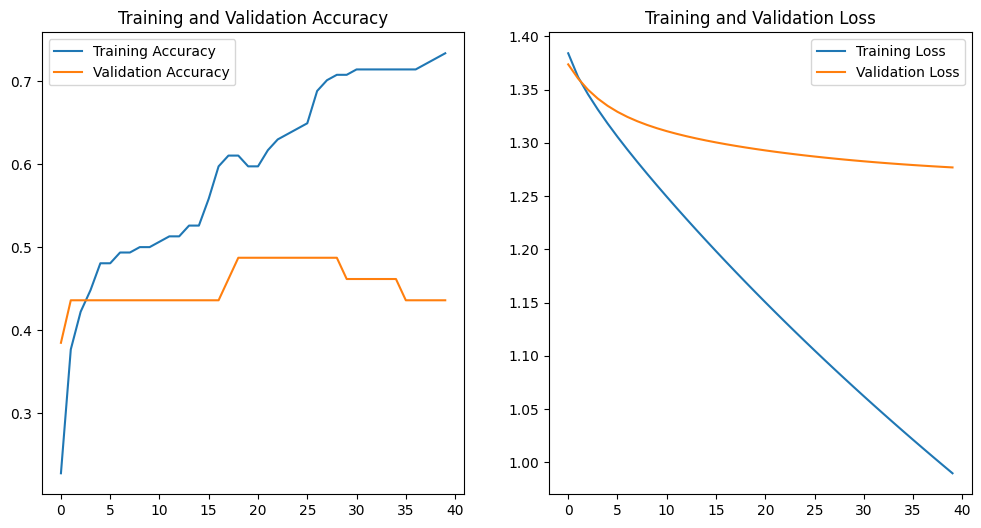

In [69]:
plot_history(history)

In [70]:
import pickle

# model_path = "/content/drive/My Drive/Colab Notebooks/caucus_model.pkl"
# with open(model_path, 'wb') as f:
#     pickle.dump(caucus_model, f)

#Saved Best Model – Validation accuracy ~56%